In [1]:
import pickle
from collections import defaultdict, Counter
from itertools import permutations

from statsmodels.iolib.summary2 import summary_col

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import pyobjclipboard

In [2]:
class Model_Output:
    def __init__(self, model):
        '''
        Store data from model run.
        '''
        self.agent_vars = model.datacollector.get_agent_vars_dataframe()
        self.model_vars = model.datacollector.get_model_vars_dataframe()
        self.log = model.log

In [3]:
params = {
    "font.family": 'serif',
    "font.serif": ["Computer Modern"],
    'text.usetex': True,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'axes.labelsize': 14

   }
plt.rcParams.update(params)

# Load data

## ICEWS

Data prepared in 6.05 ICEWS Aggregation

In [4]:
icews = pd.read_csv("Negative_Dyads_2005-2006.csv")
icews = icews[["Source_Country", "Target_Country", "Event_ID"]]
icews.rename(columns={"Event_ID": "Count"}, inplace=True)

icews.replace("Democratic Republic of Congo", "Democratic Republic of the Congo", inplace=True)
icews.replace("Russian Federation", "Russia", inplace=True)
icews.replace("United States", "United States of America", inplace=True)

## Model outputs

In [5]:
experiment_labels = {
            "1a": "1_1",
            "1b": "2_1",
            "2a": "3_2",
            "2b": "3_1",
            "3a": "4_3",
            "3b": "4_1"}
experiment_keys = ["1a", "1b", "2a", "2b", "3a", "3b"]

In [6]:
agents = pd.read_csv("ICEWS_2004_agents.csv")
actors = agents.Name.unique()

# Model Data

In [7]:
datasets = {}
for key, val in experiment_labels.items():
    path = "data_output/ICEWS_Ex{}.pickle".format(val)
    with open(path, "rb") as f:
        all_models = pickle.load(f)
        
    # Count conflicts across each dyad
    conflict_dyads = Counter()

    for i, model in enumerate(all_models):
        for event in model.log.get_events(action="Attack"):
            source = event.source
            target = event.target
            dyad = (source, target)
            conflict_dyads[dyad] += 1

    # Fill in zeroes
    for source, target in permutations(actors, 2):
        dyad = (source, target)
        if dyad not in conflict_dyads:
            conflict_dyads[dyad] = 0
            
    model_conflicts = pd.DataFrame({"Model_Conflicts": dict(conflict_dyads)})
    model_conflicts.reset_index(inplace=True)
    model_conflicts.rename(columns={"level_0": "Source_Country",
                                   "level_1": "Target_Country"}, inplace=True)

    df = model_conflicts.merge(icews, how="left", on=["Source_Country", "Target_Country"])
    df.rename(columns={"Count": "ICEWS_Count"}, inplace=True)
    df.fillna(0, inplace=True)
    df.Model_Conflicts /= 100
    
    datasets[key] = df

# Scatter plots

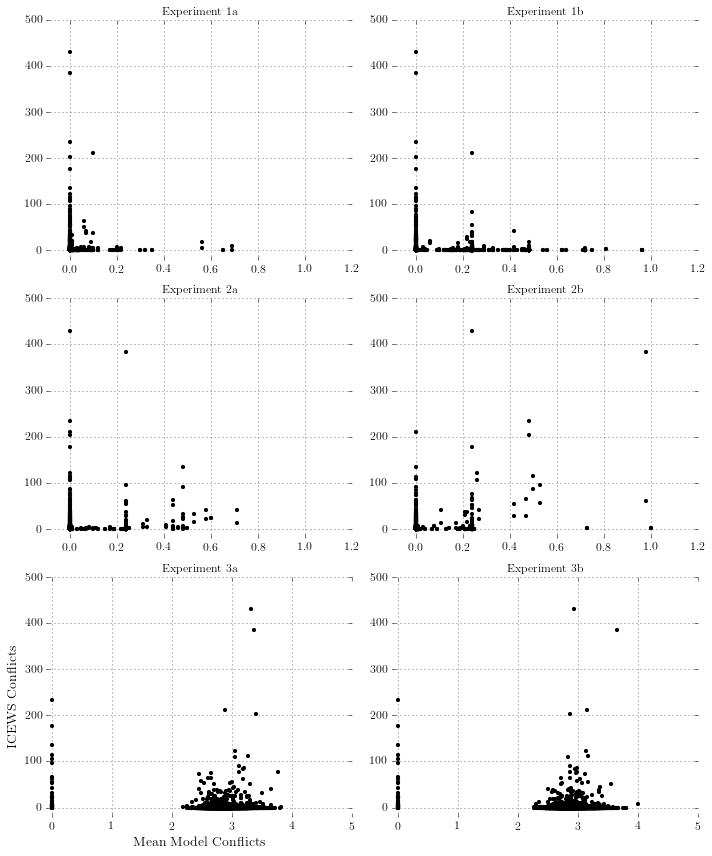

In [8]:
fig = plt.figure(figsize=(10, 12))
for i, ex in enumerate(experiment_keys):
    ax = fig.add_subplot(3, 2, i+1)
    df = datasets[ex]
    ax.scatter(df.Model_Conflicts, df.ICEWS_Count, c='k', s=10)
    if i == 4:
        ax.set_xlabel("Mean Model Conflicts")
        ax.set_ylabel("ICEWS Conflicts")
    ax.grid(True)
    ax.set_title("Experiment {}".format(ex.replace("_", ".")))
    _, x_max = ax.get_xlim()
    if x_max < 2:
        ax.set_xlim(-0.1, 1.2)
    else:
        ax.set_xlim(-0.1, x_max)
    ax.set_ylim(-20, 500)
    
    for spine in ["top", "left", "right", "bottom"]:
        ax.spines[spine].set_visible(False)

fig.tight_layout()

In [9]:
PATH = "/Users/dmasad/Documents/Dissertation/Dissertation/BDM_Reproduction/Figures/"
fig.savefig(PATH + "ICEWS_Scatters.pdf")

# Econometric models

In [10]:
import statsmodels.api as sm

## Linear models

In [11]:
linear_models = []
for ex in experiment_keys:
    df = datasets[ex]
    df["Const."] = 1
    lm = sm.OLS(df["ICEWS_Count"], df[["Const.", "Model_Conflicts"]]).fit()
    linear_models.append(lm)

In [12]:
lm_table = summary_col(linear_models, float_format="%.2f", stars=True,
                      model_names=[ex for ex in experiment_keys],
                      info_dict={"R^2": 
                                 lambda x: "{:.2f}".format(x.rsquared)})

/Users/dmasad/.virtualenvs/consul/lib/python3.4/site-packages/statsmodels/iolib/summary2.py:372: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  res.ix[:, 0][idx] = res.ix[:, 0][idx] + '*'
/Users/dmasad/.virtualenvs/consul/lib/python3.4/site-packages/statsmodels/iolib/summary2.py:374: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  res.ix[:, 0][idx] = res.ix[:, 0][idx] + '*'
/Users/dmasad/.virtualenvs/consul/lib/python3.4/site-packages/statsmodels/iolib/summary2.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/ind

In [13]:
print(lm_table)


                   1a      1b       2a       2b       3a       3b   
--------------------------------------------------------------------
Const.          2.82*** 3.91***  2.27***  1.40***  20.37*** 21.80***
                (0.35)  (0.44)   (0.35)   (0.33)   (2.10)   (2.10)  
Model_Conflicts 6.82    -7.90*** 33.58*** 94.31*** -6.20*** -6.64***
                (8.61)  (1.99)   (4.57)   (4.38)   (0.73)   (0.73)  
R^2             0.00    0.01     0.02     0.16     0.03     0.03    
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


In [17]:
print(lm_table.as_latex())

\begin{table}
\caption{}
\begin{center}
\begin{tabular}{lcccccc}
\hline
                &    1a   &    1b    &    2a    &    2b    &    3a    &    3b     \\
\hline
\hline
\end{tabular}
\begin{tabular}{lllllll}
Const.          & 2.82*** & 3.91***  & 2.27***  & 1.40***  & 20.37*** & 21.80***  \\
                & (0.35)  & (0.44)   & (0.35)   & (0.33)   & (2.10)   & (2.10)    \\
Model_Conflicts & 6.82    & -7.90*** & 33.58*** & 94.31*** & -6.20*** & -6.64***  \\
                & (8.61)  & (1.99)   & (4.57)   & (4.38)   & (0.73)   & (0.73)    \\
R^2             & 0.00    & 0.01     & 0.02     & 0.16     & 0.03     & 0.03      \\
\hline
\end{tabular}
\end{center}
\end{table}


## Logits

In [14]:
logit_models = []
for ex in experiment_keys:
    df = datasets[ex]
    df["Const."] = 1
    df["ICEWS_Dummy"] = 0
    df.loc[df.ICEWS_Count>0, "ICEWS_Dummy"] = 1
    logit = sm.Logit(df.ICEWS_Dummy, df[["Const.", "Model_Conflicts"]])\
        .fit()
    logit_models.append(logit)

Optimization terminated successfully.
         Current function value: 0.545374
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.543086
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.527765
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.520126
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.529736
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.527016
         Iterations 6


In [15]:
logit_table = summary_col(logit_models, float_format="%.2f", stars=True,
                      model_names=[ex for ex in experiment_keys],
                      info_dict={"Pseudo-R^2": 
                                 lambda x: "{:.2f}".format(x.prsquared)})

/Users/dmasad/.virtualenvs/consul/lib/python3.4/site-packages/statsmodels/iolib/summary2.py:372: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  res.ix[:, 0][idx] = res.ix[:, 0][idx] + '*'
/Users/dmasad/.virtualenvs/consul/lib/python3.4/site-packages/statsmodels/iolib/summary2.py:374: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  res.ix[:, 0][idx] = res.ix[:, 0][idx] + '*'
/Users/dmasad/.virtualenvs/consul/lib/python3.4/site-packages/statsmodels/iolib/summary2.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/ind

In [16]:
print(logit_table)


                   1a       1b       2a       2b       3a       3b   
---------------------------------------------------------------------
Const.          -1.19*** -1.03*** -1.30*** -1.32*** 1.22***  1.47*** 
                (0.05)   (0.06)   (0.05)   (0.05)   (0.30)   (0.31)  
Model_Conflicts 2.27**   -1.15*** 5.52***  8.01***  -0.86*** -0.94***
                (1.03)   (0.30)   (0.62)   (0.81)   (0.10)   (0.11)  
Pseudo-R^2      0.00     0.01     0.03     0.05     0.03     0.04    
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


In [18]:
print(logit_table.as_latex())

\begin{table}
\caption{}
\begin{center}
\begin{tabular}{lcccccc}
\hline
                &    1a    &    1b    &    2a    &    2b    &    3a    &    3b     \\
\hline
\hline
\end{tabular}
\begin{tabular}{lllllll}
Const.          & -1.19*** & -1.03*** & -1.30*** & -1.32*** & 1.22***  & 1.47***   \\
                & (0.05)   & (0.06)   & (0.05)   & (0.05)   & (0.30)   & (0.31)    \\
Model_Conflicts & 2.27**   & -1.15*** & 5.52***  & 8.01***  & -0.86*** & -0.94***  \\
                & (1.03)   & (0.30)   & (0.62)   & (0.81)   & (0.10)   & (0.11)    \\
Pseudo-R^2      & 0.00     & 0.01     & 0.03     & 0.05     & 0.03     & 0.04      \\
\hline
\end{tabular}
\end{center}
\end{table}
